# Temporal-Difference Methods

my own implementations of many Temporal-Difference (TD) methods.
- sarsa
- Q-learning
- Expected Sarsa

### Explore CliffWalkingEnv

In [14]:
import sys
import gym
import random
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

In [15]:
env = gym.make('CliffWalking-v0')

According to OpenAI gym, the agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
`36` is the initial state, `47` is the terminal state, the rest are cliff.

The agent has 4 actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

In [16]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


### Optimal state-value function

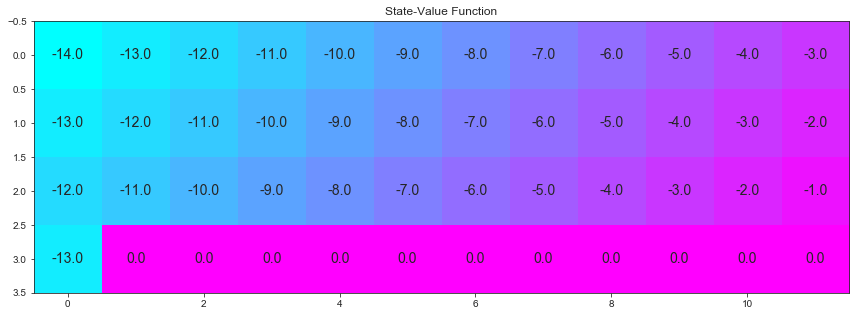

In [17]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Sarsa

Arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [18]:
def update_sarsa_Q(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    '''returns updated Q-value from most recent SAR'''
    # get current and next Q
    current = Q[state][action]
    Q_next = Q[next_state][next_action] if next_state is not None else 0 
    # get next reward
    new_val = current + (alpha * (reward + (gamma * Q_next) - current))
    return new_val

def epsilon_greedy(Q, state, nA, eps):
    '''selects epsilon-greedy action'''
    if random.random() > eps:
        return np.argmax(Q[state])
    else:
        return random.choice(np.arange(env.action_space.n))

In [19]:
def sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    # number of possible actions
    nA = env.action_space.n
    
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    # initialize performance monitor (deque is very fast)
    tmp_scores = deque(maxlen = plot_every)
    avg_scores = deque(maxlen = num_episodes)
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        # score as 0, reset state, get epsilon and action
        score = 0
        state = env.reset()
        eps = 1.0 / i_episode
        
        while True:
            action = epsilon_greedy(Q, state, nA, eps)
            next_state, reward, done, info = env.step(action)
            score += reward
            if not done:
                # continue to the next SAR cycle
                next_action = epsilon_greedy(Q, next_state, nA, eps)
                Q[state][action] = update_sarsa_Q(alpha, gamma, Q, state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                # update Q one last time in this episode and record score
                Q[state][action] = update_sarsa_Q(alpha, gamma, Q, state, action, reward)
                tmp_scores.append(score)
                break
        
        # organize plot data
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
              
    plt.plot(np.linspace(0, num_episodes, len(avg_scores), endpoint=False), np.asarray(avg_scores))
    plt.xlabel("Episode")
    plt.ylabel("Average Reward (over %d episodes)" % plot_every)
    plt.show()
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q

Episode 5000/5000

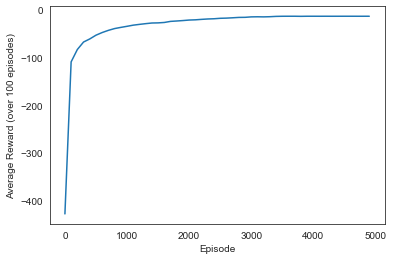

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  1  1  3  0  0  2  1  1  2  0]
 [ 1  1  1  1  0  1  1  2  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


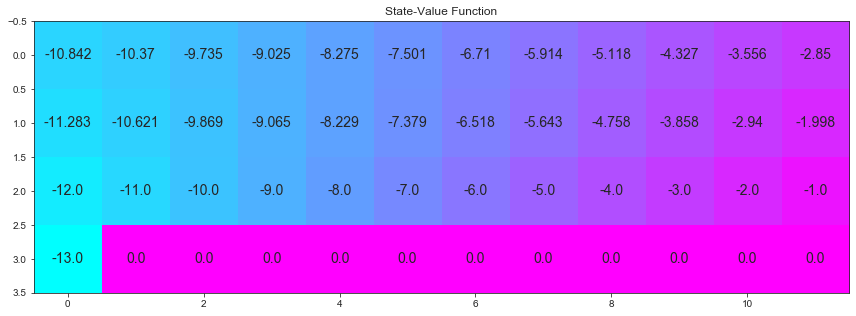

In [20]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Q-learning

Same arguments as Sarsa.

In [21]:
def update_sarsamax_Q(alpha, gamma, Q, state, action, reward, next_state=None):
    '''returns updated Q-value from most recent SAR'''
    # get current and next Q
    current = Q[state][action]
    Q_next = np.max(Q[next_state]) if next_state is not None else 0 
    # get next reward
    new_val = current + (alpha * (reward + (gamma * Q_next) - current))
    return new_val

In [22]:
def q_learning(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    # number of possible actions
    nA = env.action_space.n
    
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    # initialize performance monitor (deque is very fast)
    tmp_scores = deque(maxlen = plot_every)
    avg_scores = deque(maxlen = num_episodes)
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        # score as 0, reset state, get epsilon and action
        score = 0
        state = env.reset()
        eps = 1.0 / i_episode
        
        while True:
            action = epsilon_greedy(Q, state, nA, eps)
            next_state, reward, done, info = env.step(action)
            score += reward
            Q[state][action] = update_sarsamax_Q(alpha, gamma, Q, state, action, reward, next_state)
            
            state = next_state
            if done:
                # record score
                tmp_scores.append(score)
                break
        
        # organize plot data
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
              
    plt.plot(np.linspace(0, num_episodes, len(avg_scores), endpoint=False), np.asarray(avg_scores))
    plt.xlabel("Episode")
    plt.ylabel("Average Reward (over %d episodes)" % plot_every)
    plt.show()
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q

Episode 5000/5000

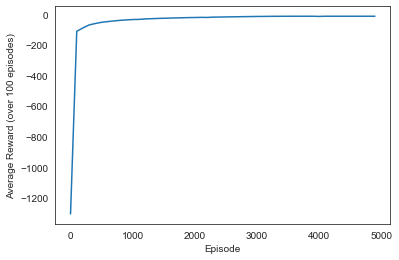

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 2  1  1  1  1  1  1  1  1  1  1  0]
 [ 0  2  0  1  3  2  3  1  2  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


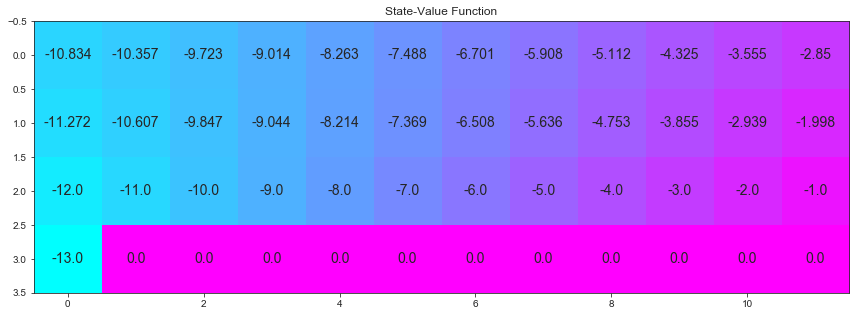

In [23]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Expected Sarsa

Same arguments as Sarsa.

In [24]:
def update_expsarsa_Q(alpha, gamma, nA, eps, Q, state, action, reward, next_state=None):
    '''returns updated Q-value from most recent SAR'''
    # get current and next Q
    current = Q[state][action]
    # add up to be epsilon
    policy_s = np.ones(nA) * eps / nA
    # cell with the largest q value get the most possibility
    policy_s[np.argmax(Q[next_state])] = 1 - eps + eps / nA
    # value of state taking into account all possibilities (summation)
    Q_next = np.dot(Q[next_state], policy_s)
    # get next reward
    new_val = current + (alpha * (reward + (gamma * Q_next) - current))
    return new_val

In [25]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    # number of possible actions
    nA = env.action_space.n
    
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    # initialize performance monitor (deque is very fast)
    tmp_scores = deque(maxlen = plot_every)
    avg_scores = deque(maxlen = num_episodes)
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        score = 0
        state = env.reset()
        # 0.5% rate for epsilon, small but constant
        eps = 0.005
        
        # same as before
        while True:
            action = epsilon_greedy(Q, state, nA, eps)
            next_state, reward, done, info = env.step(action)
            score += reward
            # update Q
            Q[state][action] = update_expsarsa_Q(alpha, gamma, nA, eps, Q, state, action, reward, next_state)
            state = next_state
            if done:
                tmp_scores.append(score)
                break
                
        if (i_episode & plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    plt.plot(np.linspace(0, num_episodes, len(avg_scores), endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
        
    return Q

Episode 10000/10000

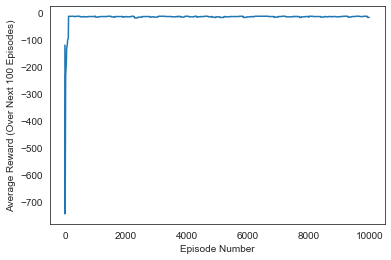

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  0  1  1  1  0  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


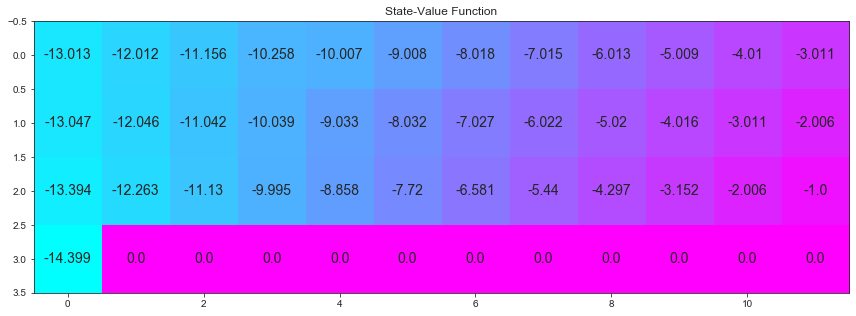

In [26]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])